In [3]:
import os
import sys
import operator
from pathlib import Path
from dotenv import load_dotenv
from langchain_core.documents import Document

# 프로젝트 루트를 Python 경로에 추가 (rag 모듈 import를 위해 필요)
project_root = Path().resolve().parent if Path().resolve().name == "LangGraph" else Path().resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"✅ 프로젝트 루트 추가됨: {project_root}")

✅ 프로젝트 루트 추가됨: C:\Users\rkddn\YAI-NLP


In [4]:
from huggingface_hub import login
hf_token = os.getenv("HF_API_KEY")
if hf_token:
    os.environ["HF_API_KEY"] = hf_token
else:
    print("⚠️ 경고: HF_API_KEY이 없습니다.")

login(token=os.getenv("HF_API_KEY"))

In [5]:
from rag.ingest import ingest_documents, ingest_pdfs

ingest_pdfs(
    pdf_paths=["nlp.pdf"],
    persist_directory="./chroma_db",
    collection_name="my_collection",
)
ingest_documents(
    file_paths=["highmath12.txt"],
    persist_directory="./chroma_db",
    collection_name="my_collection",
)

Could not get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could not get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could not get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could not get FontBBox from font descriptor because None cannot be parsed as 4 floats


  📄 nlp.pdf: 7페이지 로드
📄 총 7개 페이지 로드 완료
✂️ 총 30개 청크로 분할 완료
🌐 임베딩: API 방식 (BAAI/bge-m3)
✅ ChromaDB 저장 완료: ./chroma_db (collection: my_collection, 30개 청크)
  📄 highmath12.txt: 1개 문서 로드
📄 총 1개 문서 로드 완료
✂️ 총 16개 청크로 분할 완료
🌐 임베딩: API 방식 (BAAI/bge-m3)
✅ ChromaDB 저장 완료: ./chroma_db (collection: my_collection, 16개 청크)


In [6]:
# LangSmith 추적 설정 (langchain_teddynote 제거 → 환경변수 직접 설정)
load_dotenv()

# LangSmith 추적이 필요한 경우 아래 환경변수를 .env에 설정하거나 직접 활성화
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_PROJECT"] = "LangSmith_YAI"
# os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

True

In [7]:
# ===== 프로토타입(PDF) → 프로덕션(ChromaDB) 전환 =====
# 변수명을 retriever / chain 으로 통일하여 이후 노드 코드 수정 최소화

# ── [프로토타입] PDF 기반 (기존 코드) ────────────────────────
# from rag.pdf import PDFRetrievalChain
# print("🚀 Hugging Face 기반 PDF 체인 생성 시작...")
# _rag = PDFRetrievalChain(["nlp.pdf"]).create_chain()
# print("✅ 체인 생성 완료!")
# retriever = _rag.retriever
# chain = _rag.chain

# ── [프로덕션] ChromaDB 기반 ─────────────────────────────────
from rag.chroma import ChromaRetrievalChain

print("🚀 ChromaDB 기반 체인 생성 시작...")
_rag = ChromaRetrievalChain(
    persist_directory="./chroma_db",       # ChromaDB 저장 경로
    collection_name="my_collection",        # 컬렉션 이름
    k=10,                                   # 검색 문서 수
).create_chain()
print("✅ 체인 생성 완료!")

retriever = _rag.retriever
chain = _rag.chain

🚀 ChromaDB 기반 체인 생성 시작...
🌐 임베딩: API 방식 (BAAI/bge-m3)
📚 ChromaDB 연결 완료: 274개 문서 (collection: my_collection)
✅ 체인 생성 완료!


C:\Users\rkddn\YAI-NLP\rag\chroma.py:66: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the `langchain-chroma package and should be used instead. To use it run `pip install -U `langchain-chroma` and import as `from `langchain_chroma import Chroma``.
  self.vectorstore = Chroma(


In [8]:
# retriever 테스트 (pdf_retriever → retriever 로 통일)
# search_result = retriever.invoke("수학1 핵심 커리큘럼을 설명해주세요요")
# search_result

In [9]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

# 에이전트 상태를 정의하는 타입 딕셔너리, 메시지 시퀀스를 관리하고 추가 동작 정의
class AgentState(TypedDict):
    # add_messages reducer 함수를 사용하여 메시지 시퀀스를 관리
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [10]:
from typing import TypedDict, Annotated, List
from langgraph.graph.message import add_messages

class GraphState(TypedDict):
    #policy: Annotated[str, "Policy"] #누적됨
    question: Annotated[str, "Question"]
    context: Annotated[str, "Context"]
    answer: Annotated[str, "Answer"]
    messages: Annotated[list, add_messages] #메시지(누적되는 list)
    relevance: Annotated[str, "Relevance"]

    """
    context 구성요소
    1. 챗봇 대화 기록
    2. 웹 검색 결과
    3. 시스템 프롬프트
    4. [POLICY]
    5. 사용자 질문
    6. 최근에 retrieve 한 내용


    context내에서 처리 or retrieve?
    -> 프롬프트 내에 연관성이 있는 맥락이 있는지 서치하는 LLM 모델 필요할 듯
    """
    

<h3>Node Definition</h3>

In [11]:
#일단 Relevance용 모델 정의
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

hf_llm = HuggingFaceEndpoint(
    repo_id="meta-llama/Llama-3.1-8B-Instruct",
    task="text-generation",
    temperature=0.0,
    max_new_tokens=512,
)

chat_hf = ChatHuggingFace(llm=hf_llm)

In [12]:
from langchain_chroma import Chroma
from rag.base import create_embedding_auto


def contextualize(state: GraphState) -> GraphState:
    # recall이 필요하면 요약 DB에서 맥락을 검색한 뒤 질문을 재작성
    embeddings = create_embedding_auto()

    def _to_text(msg):
        if hasattr(msg, "type") and hasattr(msg, "content"):
            return f"{msg.type}: {msg.content}"
        if isinstance(msg, (tuple, list)) and len(msg) >= 2:
            return f"{msg[0]}: {msg[1]}"
        return str(msg)

    def _extract_question(raw_question):
        if hasattr(raw_question, "content"):
            return str(raw_question.content)
        if isinstance(raw_question, (list, tuple)) and raw_question:
            last = raw_question[-1]
            if hasattr(last, "content"):
                return str(last.content)
            return str(last)
        return str(raw_question)

    def _looks_ambiguous(q: str) -> bool:
        # judge whether the question is ambiguous
        q = (q or "").strip()
        if not q:
            return False

        ambiguous_terms = [
            "그거", "그것", "이거", "저거", "그때", "저번", "아까", "그 내용", "그 이야기",
            "기억나", "기억해", "다시", "이어", "더 자세히", "뭐였지",
        ]
        short_followups = ["왜?", "어째서?", "뭐야?", "뭔데?", "그게 뭐야?", "설명해줘"]

        return (
            any(t in q for t in ambiguous_terms)
            or q in short_followups
            or len(q) <= 8
        )

    messages = state.get("messages", [])
    question = _extract_question(state.get("question", "")).strip()
    recent_chat = "\n".join(_to_text(m) for m in messages[-10:])

    keyword_recall = any(
        keyword in question
        for keyword in ["그때", "저번에", "아까", "이전", "기억나", "위에", "그거", "내 생일", "내 정보"]
    )
    ambiguous_recall = _looks_ambiguous(question)

    llm_recall_needed = False
    recall_judgment_prompt = f"""
        당신은 질의 라우팅 판별기입니다.
        아래 사용자 질문이 과거 대화 맥락(특히 개인 정보/이전 대화 요약) 없이는 해석이 어려운지 판단하세요.

        [Recent Chat]
        {recent_chat}

        [Question]
        {question}

        출력은 반드시 아래 둘 중 하나만:
        YES
        NO
        """.strip()

    try:
        judge = chat_hf.invoke(recall_judgment_prompt)
        judge_text = (judge.content if hasattr(judge, "content") else str(judge)).strip().upper()
        llm_recall_needed = "YES" in judge_text
    except Exception:
        llm_recall_needed = False

    is_recall_needed = keyword_recall or ambiguous_recall or llm_recall_needed

    rewrite_question = question
    long_term_context = ""

    if is_recall_needed:
        print("🔍 Searching Chat History Summaries for contextual rewrite...")

        summary_store = Chroma(
            persist_directory="./chroma_db",
            collection_name="chat_history_summarized",
            embedding_function=embeddings,
        )

        # 검색용 쿼리를 먼저 생성해 모호한 표현을 보강
        retrieval_query_prompt = f"""
            사용자 질문으로 벡터 검색할 쿼리를 1문장으로 만들어주세요.
            - 과거 대화에서 찾아야 할 핵심 엔티티(예: 생일, 선호, 이전 주제)를 포함하세요.
            - 불필요한 수식어 없이 검색 친화적으로 작성하세요.
            - 질문에 답하지 말고 검색 쿼리 문장만 출력하세요.

            [Recent Chat]
            {recent_chat}

            [Question]
            {question}
            """.strip()

        retrieval_query = question
        try:
            rq = chat_hf.invoke(retrieval_query_prompt)
            candidate_query = (rq.content if hasattr(rq, "content") else str(rq)).strip()
            if candidate_query:
                retrieval_query = candidate_query
        except Exception:
            retrieval_query = question

        docs = summary_store.similarity_search(retrieval_query, k=3)
        if docs:
            long_term_context = "\n".join(d.page_content for d in docs)

        rewrite_prompt = f"""
            You are a query rewriter.
            Rewrite the user's question to be clear and standalone.
            Use retrieved long-term context if available. If not available, use only recent chat.
            Do not answer. Return only one rewritten question in Korean.

            [Recent Chat]
            {recent_chat}

            [Retrieved Long-term Context]
            {long_term_context}

            [Original Question]
            {question}
            """.strip()

        try:
            response = chat_hf.invoke(rewrite_prompt)
            candidate = (response.content if hasattr(response, "content") else str(response)).strip()
            if candidate:
                rewrite_question = candidate
        except Exception:
            rewrite_question = question

    return GraphState(question=rewrite_question)

In [13]:
import json
import re
from rag.utils import format_docs

# ※ langchain_teddynote.evaluator.GroundednessChecker 제거
# ※ langchain_teddynote.messages.messages_to_history 제거

def retrieve_or_not(state: GraphState) -> str:
    """
    사용자 질문에 대해 문서 검색(retrieve)이 필요한지 판단.
    - 검색 불필요 → "not retrieve" → llm_answer로 직행
    - 검색 필요 → "retrieve" → retrieve 노드로 이동
    Hugging Face Meta Llama(chat_hf) 사용.
    """
    question = state["question"]
    if not question:
        return "not retrieve"

    prompt = f"""
                다음 사용자 질문에 답하려면 **문서/벡터DB 검색(retrieve)**이 필요한지 판단하세요.

                판단 기준:
                - 인사, 감정, 단순 대화("안녕", "고마워", "뭐해" 등), 잡담 → 검색 불필요
                - 문서에 있을 법한 전문 지식 질문 → 검색 필요
                - 최신 정보/뉴스(노벨상, 날짜별 사건 등) → 검색 필요

                질문: {question}

                *반드시 아래 JSON 형식으로만 답하세요. 다른 텍스트 없이 JSON만 출력.
                {{"need_retrieve": "yes"}} 또는 {{"need_retrieve": "no"}}
                """

    try:
        response = chat_hf.invoke(prompt)
        text = (response.content or "").strip()
        match = re.search(r"\{[^{}]*\"need_retrieve\"[^{}]*\}", text)
        if match:
            data = json.loads(match.group(0))
            need = (data.get("need_retrieve") or "no").lower()
            if need in ("yes", "true", "1"):
                print("==============retrieve Node============")
                return "retrieve"
        print("==============go to llm_answer============")
        return "not retrieve"
    except Exception:
        return "retrieve"




"""===========노드 정의==========="""


def retrieve(state: GraphState) -> GraphState:
    """ChromaDB (또는 PDF) retriever로 문서 검색"""
    latest_question = state["question"]
    retrieved_docs = retriever.invoke(latest_question)  # pdf_retriever → retriever
    formatted_docs = format_docs(retrieved_docs)
    return GraphState(context=formatted_docs)

def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    chat_history = state.get("messages", [])
    
    try:
        response = chain.invoke(  # pdf_chain → chain
            {
                "question": latest_question,
                "context": context,
                "chat_history": chat_history,
            }
        )
    except Exception as e:
        # BadRequestError 등 상세한 에러 정보 출력
        print("=" * 80)
        print("❌ LLM 호출 중 에러 발생!")
        print("=" * 80)
        print(f"에러 타입: {type(e).__name__}")
        print(f"에러 메시지: {str(e)}")
        
        if hasattr(e, 'response'):
            resp = e.response
            print(f"\nAPI 응답 객체: {resp}")
            try:
                if hasattr(resp, 'text'):
                    print(f"API 응답 본문 (text): {resp.text}")
                elif hasattr(resp, 'content'):
                    print(f"API 응답 본문 (content): {resp.content}")
                if hasattr(resp, 'json'):
                    try:
                        error_json = resp.json()
                        print(f"API 응답 본문 (JSON): {json.dumps(error_json, indent=2, ensure_ascii=False)}")
                    except:
                        pass
            except Exception as resp_e:
                print(f"응답 본문 읽기 실패: {resp_e}")
        
        if hasattr(e, 'status_code'):
            print(f"HTTP 상태 코드: {e.status_code}")
        if hasattr(e, 'request_id'):
            print(f"Request ID: {e.request_id}")
        
        context_str = str(context)
        print("\n입력 데이터 정보:")
        print(f"  - question 길이: {len(latest_question)} 문자")
        print(f"  - context 길이: {len(context_str)} 문자")
        estimated_tokens = len(context_str) // 2
        print(f"  - context 추정 토큰 수: 약 {estimated_tokens:,} 토큰")
        print(f"  - chat_history 타입: {type(chat_history)}, 길이: {len(chat_history) if isinstance(chat_history, list) else 'N/A'}")
        print(f"\n  - context 미리보기 (처음 200자): {context_str[:200]}...")
        print("=" * 80)
        raise
    
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return GraphState(
        answer=response, messages=[("user", latest_question), ("assistant", response)]
    )

In [23]:
from datetime import datetime, timezone
import uuid
from rag.ingest import ingest_documents


def save_or_not(state: GraphState) -> str:
    return "save_chat" if len(state.get("messages", [])) > 20 else "too short"
    
def _message_to_role_content(msg):
    if hasattr(msg, "type") and hasattr(msg, "content"):
        role = "user" if msg.type == "human" else ("assistant" if msg.type == "ai" else msg.type)
        return role, str(msg.content)

    if isinstance(msg, (tuple, list)) and len(msg) >= 2:
        return str(msg[0]), str(msg[1])

    return "unknown", str(msg)


def _conversation_only(messages):
    conv = []
    for m in messages:
        role, content = _message_to_role_content(m)
        if role in {"user", "assistant", "human", "ai"}:
            conv.append((role, content))
    return conv


def save_memory(state: GraphState) -> GraphState:
    """
    누적 대화가 충분할 때 오래된 5턴(=10 messages)을
    raw/summary 컬렉션에 각각 저장한다.
    """
    messages = state.get("messages", [])
    conv_messages = _conversation_only(messages)

    min_messages_for_5_turns = 10
    if len(conv_messages) < min_messages_for_5_turns:
        print(f"ℹ️ save_memory skip: 대화 메시지 {len(conv_messages)}개 (< 10)")
        return {}

    oldest_chunk = conv_messages[:min_messages_for_5_turns]
    raw_text = "\n".join([f"{r}: {c}" for r, c in oldest_chunk]).strip()
    if not raw_text:
        print("ℹ️ save_memory skip: 저장할 raw_text가 비어있음")
        return {}

    summary_prompt = f"""
        다음은 사용자-어시스턴트 대화의 오래된 5턴입니다.
        핵심 사실(개인정보/선호/약속/중요 맥락)만 한국어로 4~6문장 내로 요약하세요.
        질문에 답하지 말고, 메모리 저장용 요약만 출력하세요.

        [Conversation]
        {raw_text}
        """.strip()

    try:
        summary_resp = chat_hf.invoke(summary_prompt)
        summary_text = (
            summary_resp.content if hasattr(summary_resp, "content") else str(summary_resp)
        ).strip()
    except Exception as e:
        print(f"⚠️ 요약 생성 실패: {e}")
        summary_text = raw_text[:1200]

    ts = datetime.now(timezone.utc).isoformat()
    memory_id = uuid.uuid4().hex

    raw_doc = Document(
        page_content=raw_text,
        metadata={
            "source": "chat_history_raw",
            "memory_id": memory_id,
            "saved_at": ts,
            "turn_count": 5,
            "message_count": min_messages_for_5_turns,
        },
    )

    summary_doc = Document(
        page_content=summary_text,
        metadata={
            "source": "chat_history_summarized",
            "memory_id": memory_id,
            "saved_at": ts,
            "turn_count": 5,
            "message_count": min_messages_for_5_turns,
        },
    )

    try:
        ingest_documents(
            documents=[raw_doc],
            persist_directory="./chroma_db",
            collection_name="chat_history_raw",
            chunk_size=1200,
            chunk_overlap=120,
        )
        ingest_documents(
            documents=[summary_doc],
            persist_directory="./chroma_db",
            collection_name="chat_history_summzrized",
            chunk_size=400,
            chunk_overlap=40,
        )
        print(
            "✅ save_memory 완료: "
            "chat_history_raw + chat_history_summzrized 저장"
        )
    except Exception as e:
        print(f"⚠️ save_memory 저장 실패: {e}")

    return {}

Relevance Check Node (question-retrieve)

In [24]:
import json
import re

def relevance_check(state: GraphState) -> GraphState:
    prompt = f"""
        You are a grader assessing whether a retrieved document is relevant to the given question.
        Return ONLY valid JSON like: {{"score": "yes"}} or {{"score": "no"}}.

        Question:
        {state["question"]}

        Retrieved document:
        {state["context"]}
        """.strip()

    # HF 모델 호출
    response = chat_hf.invoke(prompt)

    # ChatHuggingFace는 보통 response.content에 텍스트가 들어있음
    text = response.content.strip()

    # JSON만 추출 (모델이 앞뒤에 텍스트를 섞는 경우 대비)
    match = re.search(r"\{.*\}", text, re.DOTALL)
    if match:
        text = match.group(0)

    try:
        data = json.loads(text)
        score = data.get("score", "no").lower()
    except Exception:
        score = "no"

    if score not in ["yes", "no"]:
        score = "no"

    print("==== [RELEVANCE CHECK] ====")
    print(score)

    return {"relevance": score}

def is_relevant(state: GraphState) -> str:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"

Web Search Node & Summarization

In [25]:
# ※ langchain_teddynote.tools.tavily.TavilySearch 제거
#   → langchain_community.tools.tavily_search.TavilySearchResults 사용

from langchain_community.tools.tavily_search import TavilySearchResults

MAX_TOKENS_PER_DOC = 1000
CHARS_PER_TOKEN_EST = 1.5
MAX_CHARS_PER_DOC = int(MAX_TOKENS_PER_DOC * CHARS_PER_TOKEN_EST)  # 약 1500자


def _summarize_if_long(content: str, llm, max_chars: int = MAX_CHARS_PER_DOC) -> str:
    """텍스트가 max_chars를 초과하면 LLM으로 요약."""
    if len(content) <= max_chars:
        return content
    prompt = (
        f"아래 텍스트를 핵심만 남겨 {max_chars}자 이내로 요약해주세요. "
        f"요약은 한글로 작성하고, 불필요한 반복은 제거하세요. 요약만 출력하세요.\n\n"
        f"---\n{content[:8000]}\n---"
    )
    try:
        response = llm.invoke(prompt)
        text = (response.content if hasattr(response, "content") else str(response)).strip()
        return text[:max_chars]
    except Exception:
        return content[:max_chars] + "..."


def web_search(state: GraphState) -> GraphState:
    """
    웹 검색 노드
    langchain_community의 TavilySearchResults 사용 (langchain_teddynote 의존 제거)
    """
    tavily_tool = TavilySearchResults(
        max_results=5,
        search_depth="basic",
    )

    search_query = state["question"]
    search_results = tavily_tool.invoke(search_query)
    # search_results: List[dict] → 각 dict에 'url', 'content' 키 존재

    # 검색 결과를 context 문자열로 포맷팅
    context_parts = []
    for result in search_results:
        url = result.get("url", "")
        content = result.get("content", "")

        # 긴 결과는 요약
        content = _summarize_if_long(content, chat_hf)
        context_parts.append(f"{content}\n출처: {url}")

    formatted_context = "\n\n---\n\n".join(context_parts)

    if formatted_context.strip():
        doc = Document(
            page_content=formatted_context,
            metadata={
                "source": f"web_search:{search_query}",
                "origin": "travily_merged",
            },
        )

        try:
            ingest_documents(
                documents=[doc],
                persist_directory="./chroma_db",
                collection_name="my_collection",
            )
            print(
                f'✅ 웹 검색 결과가 ChromaDB에 저장되었습니다 '
                f'(collection="my_collection)", source="web_search:{search_query}")'
            )
        except Exception as e:
            print(f"⚠️ 웹 검색 결과 저장 중 오류 발생: {e}")

    return GraphState(context=formatted_context)


<h3>그래프 생성</h3>

In [26]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(GraphState)

workflow.add_node("contextualize", contextualize)
workflow.add_node("save_memory", save_memory)
workflow.add_node("retrieve", retrieve)
workflow.add_node("llm_answer", llm_answer)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("web_search", web_search)

workflow.add_conditional_edges(
    "contextualize",
    retrieve_or_not,
    {
        "retrieve": "retrieve",
        "not retrieve": "llm_answer",
    },
)

workflow.add_edge("retrieve", "relevance_check")

workflow.add_conditional_edges(
    "relevance_check",
    is_relevant,
    {
        "relevant": "llm_answer",
        "not relevant": "web_search",
    },
)
workflow.add_edge("web_search", "llm_answer")

workflow.add_conditional_edges(
    "llm_answer",
    save_or_not,
    {
        "save_chat": "save_memory",
        "too short": END,
    },
)

workflow.add_edge("save_memory", END)
workflow.set_entry_point("contextualize")
memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

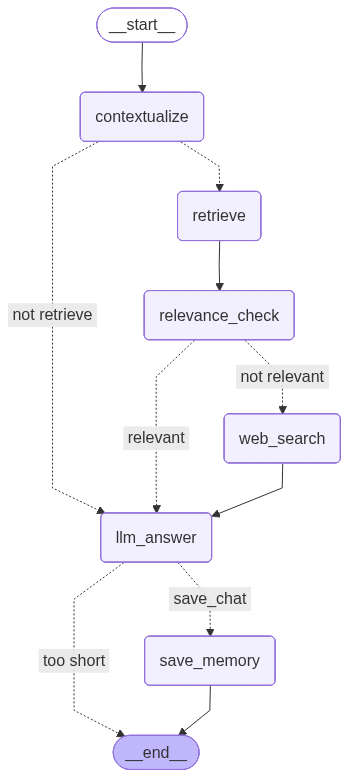

In [27]:
# ※ langchain_teddynote.graphs.visualize_graph 제거 → 자체 구현 사용
from rag.graph_utils import visualize_graph

visualize_graph(app)

<h3>그래프 실행</h3>

In [28]:
# ※ langchain_teddynote.messages 제거 → rag.graph_utils 사용
from langchain_core.runnables import RunnableConfig
from rag.graph_utils import invoke_graph, random_uuid

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

inputs = GraphState(question="팔란티어에 대해 설명해줘")

invoke_graph(app, inputs, config)

🌐 임베딩: API 방식 (BAAI/bge-m3)
🔍 Searching Chat History Summaries for contextual rewrite...
==============retrieve Node============

🔄 Node: contextualize 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
question:
 팔란티어에 대해 설명해 줄 수 있는 내용은 무엇이고, 이에 대한 정확한 정보를 어디서 찾을 수 있는지 알려줄 수 있나요?

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
  ---

**더 깊이 알아볼 수 있는 다음 단계는 무엇인가요?**
원하신다면, **"수학 II의 킬러 문항에서 자주 출제되는 3차 함수의 비율 관계"**에 대해 텍스트로 자세히 설명해 드릴 수 있습니다. highmath12.txt  
 ---

**더 깊이 알아볼 수 있는 다음 단계는 무엇인가요?**
원하신다면, **"수학 II의 킬러 문항에서 자주 출제되는 3차 함수의 비율 관계"**에 대해 텍스트로 자세히 설명해 드릴 수 있습니다. highmath12.txt  
 ---

**더 깊이 알아볼 수 있는 다음 단계는 무엇인가요?**
원하신다면, **"수학 II의 킬러 문항에서 자주 출제되는 3차 함수의 비율 관계"**에 대해 텍스트로 자세히 설명해 드릴 수 있습니다. highmath12.txt  
 ---

**더 깊이 알아볼 수 있는 다음 단계는 무엇인가요?**
원하신다면, **"수학 II의 킬러 문항에서 자주 출제되는 3차 함수의 비율 관계"**에 대해 텍스트로 자세히 설명해 ...
==== [RELEVANCE CHECK] ====
no

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
 no
📄 Docum

{'question': '팔란티어에 대해 설명해 줄 수 있는 내용은 무엇이고, 이에 대한 정확한 정보를 어디서 찾을 수 있는지 알려줄 수 있나요?',
 'context': '팔란티어는 흔히 기술의 잠재력을 조명하는 방식으로 설명되곤 한다. 하지만 이는 팔란티어라는 복잡한 기업의 한 단면에 지나지 않는다.\n출처: https://blog.naver.com/simula/224010680924?\n\n---\n\n팔란티어는 스스로를 데이터 플랫폼이 아니라 조직이 데이터를 바탕으로 실제로 움직이게 만드는 운영체제라고 정의합니다. 즉 데이터를 \'보여주는\' 것이\n출처: https://brunch.co.kr/@acc9b16b9f0f430/202\n\n---\n\n팔란티어는 종종 데이터 브로커, 데이터 마이너, 혹은 거대한 개인정보 데이터베이스라고 불린다. 실상 팔란티어는 이 중 어느 것에도 해당하지\n출처: https://ebadak.news/2025/08/13/palantir-what-the-company-does/\n\n---\n\n"AI 소프트웨어의 미래는 어떤 모습일까?" TIGER ETF가 전 세계 최초로 팔란티어(Palantir) 본사 사무실 내부 공개 허락을 받아 미국 현지로 날아\n출처: https://www.youtube.com/watch?v=H6mjzGM1hDk\n\n---\n\n| **부채** | 12억 4,647만 달러 (2024년 연결) |. | **자본** | 50억 327만 달러 (2024년 연결) |. | **매출** | 28억 6,550만 달러 (2024년 연결) |. | **영업이익** | 3억 1,040만 달러 (2024년 연결) |. 수수료 부담이 적고 상장 후 초기 매도 제한이 없는 직상장의 장점을 활용하기 위한 것으로 보인다.") (2020년 9월 30일~2024년 11월 26일) |. | **시가총액** | 4,082억 달러 (2025년 11월 14일 기준) |. 2002년 온라인 경매 플랫폼 서비스 기업 eBay(이베이)에 

In [29]:
# ※ langchain_teddynote.messages 제거 → rag.graph_utils 사용
from rag.graph_utils import stream_graph

stream_graph(app, inputs, config)

🌐 임베딩: API 방식 (BAAI/bge-m3)
🔍 Searching Chat History Summaries for contextual rewrite...
==============retrieve Node============

🔄 Node: contextualize 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
question:
 팔란티어에 대해 정확한 정의와 정보를 어디서 찾을 수 있는지 알려줄 수 있나요?

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
  팔란티어는 흔히 기술의 잠재력을 조명하는 방식으로 설명되곤 한다. 하지만 이는 팔란티어라는 복잡한 기업의 한 단면에 지나지 않는다.
출처: https://blog.naver.com/simula/224010680924?

---

팔란티어는 스스로를 데이터 플랫폼이 아니라 조직이 데이터를 바탕으로 실제로 움직이게 만드는 운영체제라고 정의합니다. 즉 데이터를 '보여주는' 것이
출처: https://brunch.co.kr/@acc9b16b9f0f430/202

--- web_search:팔란티어에 대해 설명해 줄 수 있는 내용은 무엇이고, 이에 대한 정확한 정보를 어디서 찾을 수 있는지 알려줄 수 있나요?  
 ---

팔란티어는 종종 데이터 브로커, 데이터 마이너, 혹은 거대한 개인정보 데이터베이스라고 불린다. 실상 팔란티어는 이 중 어느 것에도 해당하지
출처: https://ebadak.news/2025/08/13/palantir-what-the-company-does/

---

...
==== [RELEVANCE CHECK] ====
yes

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
 yes

🔄 Node: llm_answer 🔄
- - - 

{'question': '팔란티어에 대해 정확한 정의와 정보를 어디서 찾을 수 있는지 알려줄 수 있나요?',
 'context': ' 팔란티어는 흔히 기술의 잠재력을 조명하는 방식으로 설명되곤 한다. 하지만 이는 팔란티어라는 복잡한 기업의 한 단면에 지나지 않는다.\n출처: https://blog.naver.com/simula/224010680924?\n\n---\n\n팔란티어는 스스로를 데이터 플랫폼이 아니라 조직이 데이터를 바탕으로 실제로 움직이게 만드는 운영체제라고 정의합니다. 즉 데이터를 \'보여주는\' 것이\n출처: https://brunch.co.kr/@acc9b16b9f0f430/202\n\n--- web_search:팔란티어에 대해 설명해 줄 수 있는 내용은 무엇이고, 이에 대한 정확한 정보를 어디서 찾을 수 있는지 알려줄 수 있나요?  \n ---\n\n팔란티어는 종종 데이터 브로커, 데이터 마이너, 혹은 거대한 개인정보 데이터베이스라고 불린다. 실상 팔란티어는 이 중 어느 것에도 해당하지\n출처: https://ebadak.news/2025/08/13/palantir-what-the-company-does/\n\n---\n\n"AI 소프트웨어의 미래는 어떤 모습일까?" TIGER ETF가 전 세계 최초로 팔란티어(Palantir) 본사 사무실 내부 공개 허락을 받아 미국 현지로 날아\n출처: https://www.youtube.com/watch?v=H6mjzGM1hDk\n\n--- web_search:팔란티어에 대해 설명해 줄 수 있는 내용은 무엇이고, 이에 대한 정확한 정보를 어디서 찾을 수 있는지 알려줄 수 있나요?  \n 출처: https://namu.wiki/w/%ED%8C%94%EB%9E%80%ED%8B%B0%EC%96%B4%20%ED%85%8C%ED%81%AC%EB%86%80%EB%A1%9C%EC%A7%80%EC%8A%A4 web_search:팔란티어에 대해 설명해 줄 수 있는 내용은 무엇이고, 이에 대한 정확한 정보를 어디서 찾을

In [ ]:
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Question: 수학1 교육과정의 핵심 내용에 대해서 설명해줘
Answer:
수학 1 교육과정의 핵심 내용은 다음과 같습니다.

1.  **지수·로그함수:** 지수함수와 로그함수의 개념, 그래프 해석, 함수의 성질(증가, 감소, 극값 등)을 이해하는 것이 중요합니다.
2.  **삼각함수:** 삼각함수의 개념, 그래프 해석, 함수의 성질(증가, 감소, 극값 등)을 이해하는 것이 중요합니다.
3.  **수열:** 수열의 개념, 규칙성의 발견, 수열의 성질(증가, 감소, 극값 등)을 이해하는 것이 중요합니다.

이러한 내용을 이해하고, 그래프 추론, 속도와 가속도, 적분과 같은 주요 문제 유형을 해결할 수 있도록 훈련하는 것이 수학 1 교육과정의 핵심입니다.
